# Evaluación de la fiabilidad entre codificadores (IRR)

Fiabilidad entre evaluadores para datos de tipo nominal (documentos con respecto al tópico)  y ordinal (Calidad del tópico). Incluye:

- Porcentaje de acuerdo
- Krippendorff's Alpha
- Gwet's AC1


## Evaluación de la representatividad de los documentos con respecto a los tópicos (nominal)

En esta sección evaluamos la concordancia entre evaluadores en cuanto a la **coherencia de los tópicos**, utilizando escalas nominales (de 0 a 1).

In [6]:
import pandas as pd
import numpy as np
import krippendorff
from sklearn.metrics import cohen_kappa_score

# Cargar datos (modifica la ruta al archivo)
df = pd.read_csv("recursos/coherencia_topicos.csv",sep=";")

# Nos quedamos solo con las columnas de los evaluadores
df_coherencia = df.iloc[:, 3:]
df_coherencia.head()


,eval_1,eval_2,eval_3,eval_4
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [26]:
df_coherencia = df_coherencia.replace(2, 0) # se codificaron con 1 bien 2 mal se transforma el 2 a 0

# Distribución

In [27]:
import pandas as pd

valores = pd.value_counts(df_coherencia.values.flatten())
proporciones = valores / valores.sum()

print("Distribución de etiquetas 0 y 1:")
print(proporciones)


Distribución de etiquetas 0 y 1:
1    0.835007
0    0.164993
dtype: float64


## Porcentaje de acuerdo

In [10]:
def percent_agreement(df):
    agreements = df.apply(lambda row: len(set(row)) == 1, axis=1)
    return agreements.mean()

agreement = percent_agreement(df_coherencia)
print(f"Porcentaje de acuerdo: {agreement:.2%}")


Porcentaje de acuerdo: 72.17%


## Krippendorff’s Alpha (nominal)

In [32]:
alpha = krippendorff.alpha(df_coherencia.transpose().values, level_of_measurement='nominal')
print(f"Krippendorff’s Alpha: {alpha:.3f}")


Krippendorff’s Alpha: 0.436


## Gwet’s AC1

In [8]:
import numpy as np
import pandas as pd

def gwets_ac1_nominal(df):
    """
    Calcula Gwet's AC1 para datos nominales binarios (0/1) con múltiples codificadores.
    
    Parameters:
        df (pd.DataFrame): cada fila es un ítem, cada columna un evaluador (valores: 0 o 1)
    
    Returns:
        ac1 (float): valor de Gwet's AC1
    """
    n_items, n_raters = df.shape
    df = df.dropna()

    # Paso 1: proporción de veces que se asigna cada categoría globalmente
    ratings_flat = df.values.flatten()
    p_0 = np.mean(ratings_flat == 0)
    p_1 = np.mean(ratings_flat == 1)

    # Paso 2: acuerdo observado (Po)
    agreements = []
    for _, row in df.iterrows():
        counts = row.value_counts()
        if len(counts) == 1:
            agreements.append(1.0)
        else:
            total_pairs = n_raters * (n_raters - 1)
            agree_pairs = sum(counts[c] * (counts[c] - 1) for c in counts.index)
            agreements.append(agree_pairs / total_pairs)
    Po = np.mean(agreements)

    # Paso 3: probabilidad de acuerdo esperado por azar (Pe)
    Pe = p_0**2 + p_1**2

    # Paso 4: AC1
    ac1 = (Po - Pe) / (1 - Pe) if (1 - Pe) != 0 else np.nan
    return ac1


In [30]:
# Supón que df_rep contiene los juicios 0/1 de los evaluadores
ac1 = gwets_ac1_nominal(df_coherencia)
print(f"Gwet's AC1 (nominal): {ac1:.3f}")


Gwet's AC1 (nominal): 0.436


## Evaluación de la calidad de los tópicos (ordinal)

En esta sección evaluamos la concordancia entre evaluadores en cuanto a la **calidad de los tópicos**, utilizando escalas ordinales (de 1 a 5).

In [41]:
import pandas as pd
import numpy as np
import krippendorff
from sklearn.metrics import cohen_kappa_score
# Cargar datos de calidad de tópicos (modifica la ruta al archivo)
df_quality = pd.read_csv("calidad_topicos.csv",sep=",")
df_quality.head()


,modelo_id,topic_id,eval_1,eval_2,eval_3,eval_4
0,lda,1,5,5,5,5
1,lda,2,3,5,5,5
2,lda,3,4,4,4,4
3,lda,4,5,5,5,5
4,lda,5,5,5,4,5


In [44]:
df_eval = df_quality.iloc[:, 2:]

In [45]:
df_eval

,eval_1,eval_2,eval_3,eval_4
0,5,5,5,5
1,3,5,5,5
2,4,4,4,4
3,5,5,5,5
4,5,5,4,5
...,...,...,...,...
135,5,5,5,5
136,5,5,5,5
137,5,5,5,5
138,5,5,5,5


In [55]:
import pandas as pd

valores = pd.value_counts(df_eval.values.flatten())
proporciones = valores / valores.sum()

print("Distribución de etiquetas 1  a 5:")
print(proporciones)


Distribución de etiquetas 1  a 5:
5    0.800000
3    0.087500
4    0.087500
2    0.021429
1    0.003571
dtype: float64


### Krippendorff’s Alpha (ordinal)

In [47]:
data_quality = df_eval.transpose().values
alpha_quality = krippendorff.alpha(reliability_data=data_quality, level_of_measurement='ordinal')
print(f"Krippendorff’s Alpha (calidad de tópicos): {alpha_quality:.3f}")


Krippendorff’s Alpha (calidad de tópicos): 0.319


### Porcentaje de acuerdo (exacto)

In [35]:
def ordinal_agreement(df):
    return df.apply(lambda row: len(set(row)) == 1, axis=1).mean()
df_quality = df_quality.iloc[:, 1:]
agreement_quality = ordinal_agreement(df_quality)
print(f"Porcentaje de acuerdo exacto: {agreement_quality:.2%}")


Porcentaje de acuerdo exacto: 61.43%


In [59]:
import numpy as np
import pandas as pd
from collections import Counter

def gwet_ac2_ordinal(data):
    """
    Calcula el coeficiente AC2 de Gwet para datos ordinales (multi-evaluador, ponderado).
    
    Parámetros:
    -----------
    data : pd.DataFrame
        Cada fila representa un ítem (tópico),
        cada columna una codificación (evaluador), con valores ordinales.
    
    Retorna:
    --------
    ac2 : float
        Coeficiente AC2 de Gwet (ordinal).
    """
    N, R = data.shape
    all_labels = np.unique(data.values.ravel())
    K = len(all_labels)

    # Creamos matriz de pesos ordinales: distancia cuadrada normalizada
    weight_matrix = np.zeros((K, K))
    for i, label_i in enumerate(all_labels):
        for j, label_j in enumerate(all_labels):
            weight_matrix[i, j] = 1 - ((label_i - label_j)**2) / ((K - 1)**2)

    # Paso 1: acuerdo observado ponderado
    P_o_list = []
    for i in range(N):
        row = data.iloc[i].values
        agreement = 0
        for a in row:
            for b in row:
                i_a = np.where(all_labels == a)[0][0]
                i_b = np.where(all_labels == b)[0][0]
                agreement += weight_matrix[i_a, i_b]
        agreement = (agreement - R) / (R * (R - 1))  # quitar autocomparaciones
        P_o_list.append(agreement)
    P_o = np.mean(P_o_list)

    # Paso 2: probabilidad de cada categoría
    label_counts = Counter(data.values.ravel())
    total = N * R
    p_labels = {k: v / total for k, v in label_counts.items()}

    # Paso 3: acuerdo esperado ponderado
    P_e = 0
    for i, label_i in enumerate(all_labels):
        for j, label_j in enumerate(all_labels):
            P_e += p_labels[label_i] * p_labels[label_j] * weight_matrix[i, j]

    # Paso 4: Gwet AC2
    ac2 = (P_o - P_e) / (1 - P_e) if P_e != 1 else 1.0

    return ac2


In [60]:
ac2 = gwet_ac2_ordinal(df_eval)
print(f"Gwet's AC2 (ordinal): {ac2:.3f}")

Gwet's AC2 (ordinal): 0.322


## Cálculo por modelo


## Métricas de representatividad por modelo

In [13]:
print("=== Métricas por modelo (representatividad) ===")
for modelo, group in df.groupby("modelo_id"):
    ratings = group.iloc[:, 3:]
    ac1 = gwets_ac1_nominal(ratings)
    agreement = percent_agreement(ratings)
    alpha = krippendorff.alpha(ratings.transpose().values, level_of_measurement='nominal')
    print(f"Modelo {modelo} - Gwet's AC1: {ac1:.3f}, Krippendorff’s Alpha: {alpha:.3f}, % acuerdo: {agreement:.2%}") 

=== Métricas por modelo (representatividad) ===
Modelo Aggo_tfidf - Gwet's AC1: 0.550, Krippendorff’s Alpha: 0.463, % acuerdo: 59.00%
Modelo Aggo_w2v - Gwet's AC1: 0.454, Krippendorff’s Alpha: 0.404, % acuerdo: 71.72%
Modelo BERTOPIC - Gwet's AC1: 0.434, Krippendorff’s Alpha: 0.371, % acuerdo: 67.00%
Modelo GSDM - Gwet's AC1: 0.500, Krippendorff’s Alpha: 0.466, % acuerdo: 79.00%
Modelo Kmeans_tfidf - Gwet's AC1: 0.534, Krippendorff’s Alpha: 0.512, % acuerdo: 85.86%
Modelo Kmeans_w2v - Gwet's AC1: 0.331, Krippendorff’s Alpha: 0.250, % acuerdo: 58.00%
Modelo lda - Gwet's AC1: 0.615, Krippendorff’s Alpha: 0.591, % acuerdo: 84.85%


## Métricas de calidad de tópicos por modelo 

In [ ]:
print("\n=== Métricas por modelo (calidad de tópicos) ===")
for modelo, group in df_quality.groupby("modelo_id"):
    ratings2 = group.iloc[:, 2:]
    ac2 = gwet_ac2_ordinal(ratings2)
    alpha = krippendorff.alpha(ratings2.transpose().values, level_of_measurement='ordinal')
    print(f"Modelo {modelo} - Gwet's AC2: {ac2:.3f}, Alpha: {alpha:.3f}")        


## Mapas de calor de (des)acuerdo por modelo – Representatividad

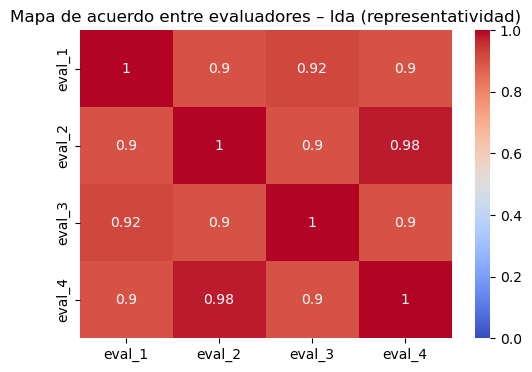

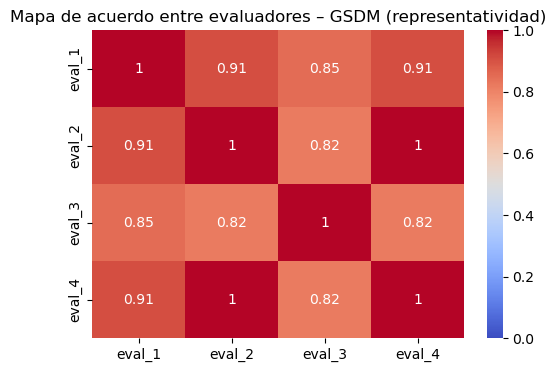

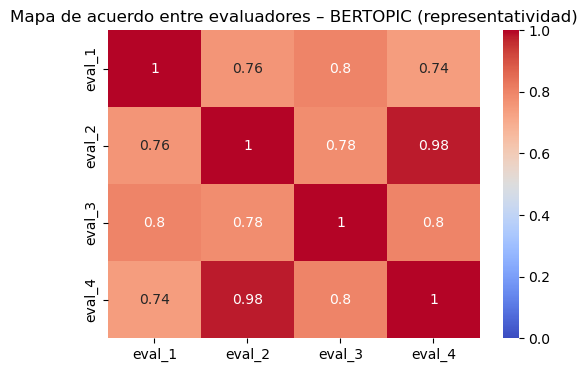

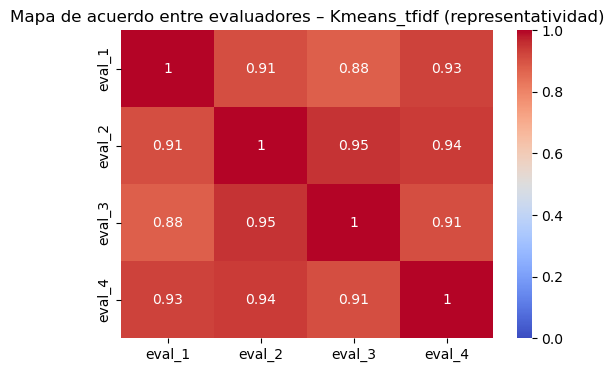

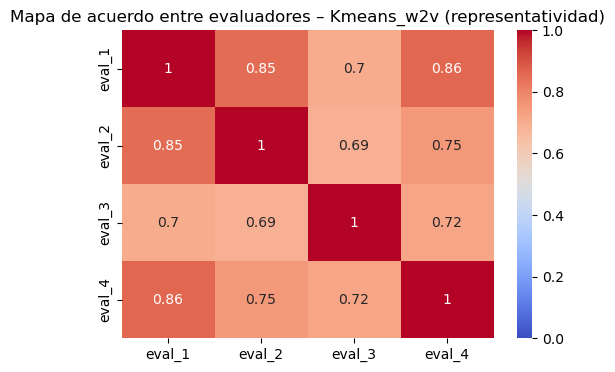

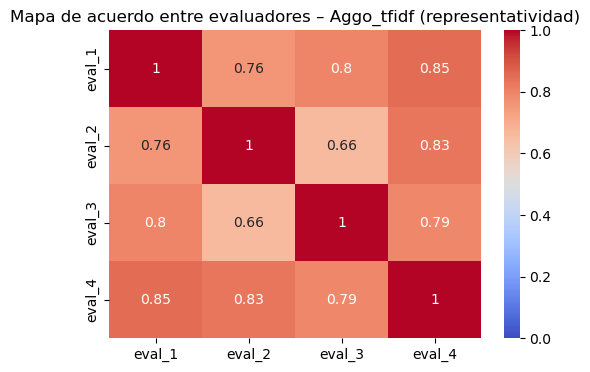

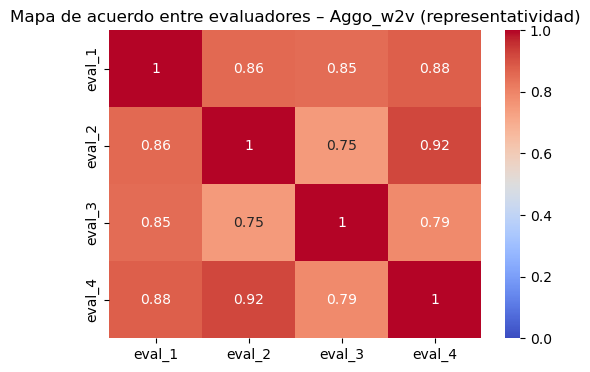

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

for modelo in df["modelo_id"].unique():
    sub_df = df[df["modelo_id"] == modelo].iloc[:, 3:]
    agreement_matrix = pd.DataFrame(index=sub_df.columns, columns=sub_df.columns)
    for i in sub_df.columns:
        for j in sub_df.columns:
            agreement_matrix.loc[i, j] = np.mean(sub_df[i] == sub_df[j])
    agreement_matrix = agreement_matrix.astype(float)

    plt.figure(figsize=(6, 4))
    sns.heatmap(agreement_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    plt.title(f"Mapa de acuerdo entre evaluadores – {modelo} (representatividad)")
    plt.show()
        

## Mapas de calor de (des)acuerdo por modelo – Calidad de tópicos

In [24]:
df_quality = pd.read_csv("recursos/calidad_topicos.csv")

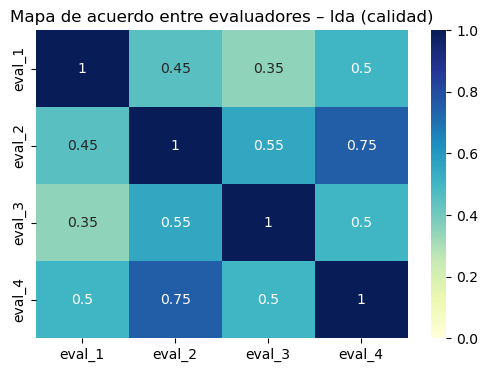

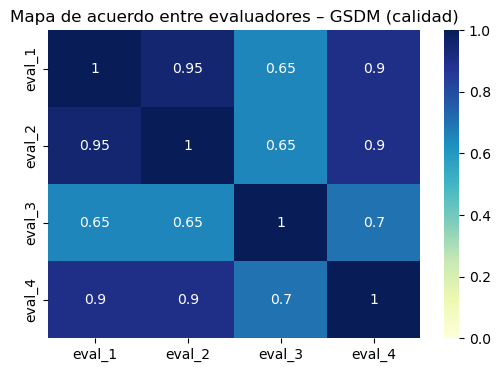

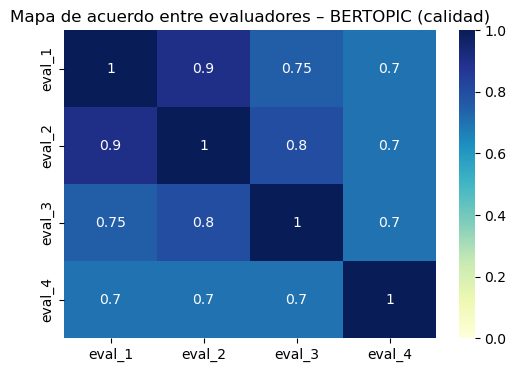

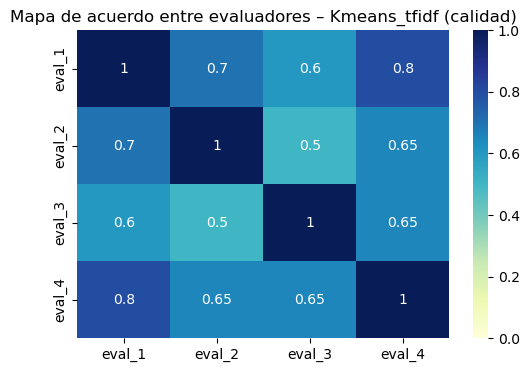

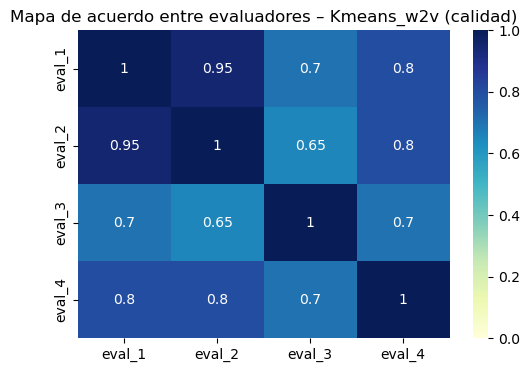

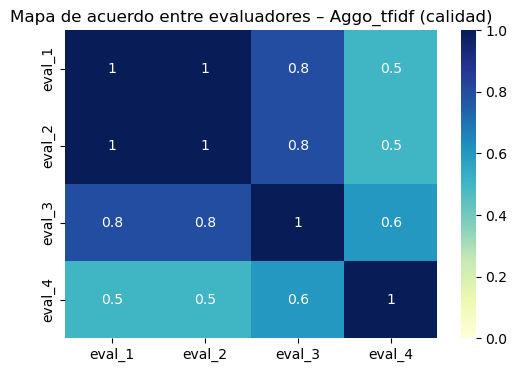

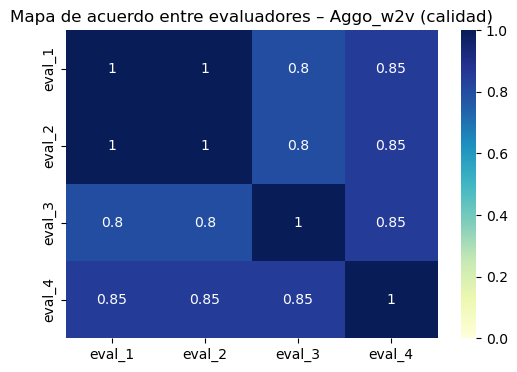

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 
for modelo in df_quality["modelo_id"].unique():
        sub_df = df_quality[df_quality["modelo_id"] == modelo].iloc[:, 2:]
        agreement_matrix = pd.DataFrame(index=sub_df.columns, columns=sub_df.columns)
        for i in sub_df.columns:
            for j in sub_df.columns:
                agreement_matrix.loc[i, j] = np.mean(sub_df[i] == sub_df[j])
        agreement_matrix = agreement_matrix.astype(float)

        plt.figure(figsize=(6, 4))
        sns.heatmap(agreement_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
        plt.title(f"Mapa de acuerdo entre evaluadores – {modelo} (calidad)")
        plt.show()   
    